In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from drive.Stanford.CS231n_master.assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!sh drive/Stanford/CS231n_master/assignment1/cs231n/datasets/get_datasets.sh

--2018-05-01 02:17:36--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.87MB/s    in 35s     

2018-05-01 02:18:12 (4.62 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
!ls

cifar-10-batches-py  datalab  drive


In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


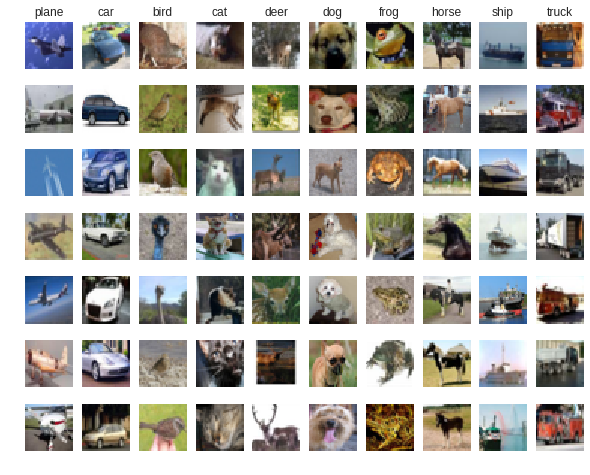

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes): # enumerate 自動生成 key value 前面用tuple 去接
    idxs = np.flatnonzero(y_train == y) # 返回扁平化后矩阵中非零元素的位置（index）
    #print("idxs",idxs)
    idxs = np.random.choice(idxs, samples_per_class, replace=False) #可以从一个int数字或1维array里随机选取内容，并将选取结果放入n维array中返回。
    for i, idx in enumerate(idxs):  
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
import numpy as np

class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  
  def __init__(self):   
    pass  

  
  
  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
    
    
    
  def predict(self, X, k=1, num_loops=0):
   
    if num_loops == 0: 
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)
  
  

  def compute_distances_two_loops(self, X):
    #使用最慢的two loops 計算歐式距離 
    num_test = X.shape[0] #500
    num_train = self.X_train.shape[0] #5000
    dists = np.zeros((num_test, num_train))# 給定一個num_test 的row, num_train的col  的二維框架 裡面全部塞0  
    for i in range(num_test):
      for j in range(num_train):

        dists[i, j] = np.sqrt(np.sum((X[i] - self.X_train[j]) ** 2))  # 直接將每一張test 照片 減掉train的所有column j 照片  存入dists內
  
    return dists # 500 5000 
  
  
  
  

  def compute_distances_one_loop(self, X):
    
    #透過廣播機制 在sum的時候 會將 二維矩陣 以最大的為主 生成一個新的二維矩陣
    
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      
      #self.X_train的大小为5000×3072，而X[i]的大小为1×3072，两者相减会自动对X[i]进行广播，使其扩展到与self.X_train相同的大小
      #里面的运算X[i] - self.X_train的结果是个5000*3072的矩阵，对这个矩阵沿着1号轴求和，从左向右数，
      #3072所在的维度就是1号轴（轴序号从0开始），因此，该维度的大小将会改变，而其它维度保持不变。
      #对于sum来说，直接把这个维度的值全部加起来，因此最后得到了长度为5000的一维矩阵。norm同理。
      dists[i, :] = np.sqrt(np.sum((X[i] - self.X_train) ** 2, axis=1))

 
    return dists






  def compute_distances_no_loops(self, X):
  
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    
    #利用(a-b)^2=a^2+b^2-2ab和numpy的broadcasting性质。
    #做反矩陣 因為矩陣需要內積 才能夠得到 推導後的公式2ab
    dists = np.multiply(np.dot(X,self.X_train.T),-2) 
    #a^2  因為axis=1 只針對shape 1  column 做平方 sum    透過keepdims=True 保持其原本陣列型態 
    sq1 = np.sum(np.square(X),axis=1,keepdims = True)  
    #b^2 因為axis=1 對xtrain 的column 平方suum
    sq2 = np.sum(np.square(self.X_train),axis=1)  
    dists = np.add(dists,sq1)  
    dists = np.add(dists,sq2)  
    dists = np.sqrt(dists)

    return dists

  
  
  
  
  
  def predict_labels(self, dists, k=1):

    num_test = dists.shape[0] #500
    y_pred = np.zeros(num_test) # 500 
    for i in range(num_test):
      
      closest_y = []
      
      closest_y = self.y_train[np.argsort(dists[i])[:k]] #argsort 將數值排序好的index 最小的index往前放  [:k] 依據K 來決定 儲存距離最近的前K個
      y_pred[i] = np.argmax(np.bincount(closest_y)) # 找出重複最多的類別
    return y_pred


In [0]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask] #篩出1~5000
y_train = y_train[mask] #
num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [0]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) #reshape -1 會將 shape(5000,32,32,3) 變成 shape(5000,3072) 
X_test = np.reshape(X_test, (X_test.shape[0], -1)) #
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
#from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.k_nearest_neighbor import KNearestNeighbor
#實作內容皆在KNearestNeighbor()內
classifier = KNearestNeighbor()
classifier.train(X_train, y_train) #intput (5000, 3072) (500, 3072)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [0]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement

# compute_distances_two_loops. 
# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test) # input(500, 3072)      output dists=(500, 5000)


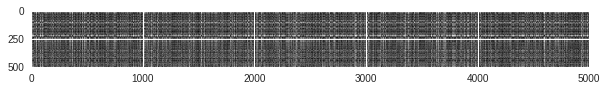

In [0]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**::** maybe they are noise, so they are distinctly different with training dataset/test dataset, or sum objects that are not in training dataset)
.*



In [0]:
#tow loop 已完成, 由此處進入predict_labels    input為 (500, 5000)    裡面是已經使用歐式距離算好的數值
y_test_pred = classifier.predict_labels(dists, k=1)

#計算準確率
num_correct = np.sum(y_test_pred == y_test) # 預測結果比對y_test  相加計算答對的分類有幾次
accuracy = float(num_correct) / num_test 
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [0]:
#計算預測的準確率
y_test_pred = classifier.predict_labels(dists, k=5) 
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [0]:
#dists_one 與 前一次 two loops 的結果 做歐式距離計算 來驗證 實作的CODE 是否正確 正確的話 誤差=0 
dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [0]:
#驗證no_loops 實作內容是否正確
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [0]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print ('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print ('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print ('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 47.558983 seconds
One loop version took 36.513975 seconds
No loop version took 0.617146 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [0]:
k_to_accuracies = {}

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
                           
for k in k_choices:
    accuracies = []
    for j in range(num_folds):
        # np.vstack 就像 concatenation axis = 0  以ROW 作為兩個list 的疊加 
        X_v = X_train_folds[j]# j 變成驗證集資料
        y_v = y_train_folds[j]
        X_tr = np.vstack(X_train_folds[0:j] + X_train_folds[j+1:]) # X_train_folds[:i] 跳過i +  X_train_folds[i+1:] 從i的下一個開始 ..
        y_tr = np.hstack(y_train_folds[0:j] + y_train_folds[j+1:])
        
        classifier.train(X_tr, y_tr) #重新帶入兩個input 
        dists = classifier.compute_distances_no_loops(X_v) # 帶入設計好的驗證集資料
        y_test_pred = classifier.predict_labels(dists, k)
        num_correct = np.sum(y_test_pred == y_v)
        accuracies.append(float(num_correct) * num_folds / num_training)
        k_to_accuracies[k] = accuracies        
        
# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print ('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

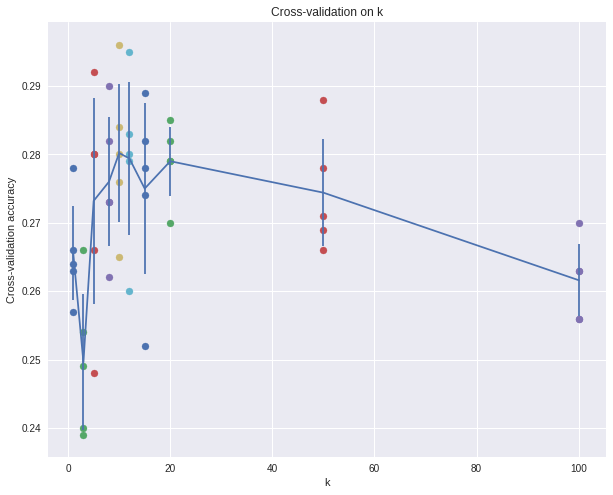

In [0]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [0]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


In [0]:
!kill -9 all